In [21]:
from collections import defaultdict
import gzip
import importlib
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os

import sys
sys.path.append("../src/utils")
from annovar_utils import *
from variant_utils import *

import evaluation_utils
importlib.reload(evaluation_utils)
from evaluation_utils import *

import comparison_utils
importlib.reload(comparison_utils)
from comparison_utils import *

In [3]:
dbGaP_stopgains_path = "/cluster/u/rrastogi/ECNN/dataset/dbGaP/data/stopgains_filtered_with_gt.tsv"
dbGaP_hg38_vcf_path = "/cluster/u/rrastogi/ECNN/dataset/dbGaP/data/hg38.vcf"
dbGaP_phenotypes_path = "/cluster/data/labResourcesStaging/dbGaP/external_package/phs001076.IBD_Exome.v1.p1.c2.GRU/PhenotypeFiles/phs001076.v1.pht005361.v1.p1.IBD_Exome_Subject.MULTI.txt.gz"

def is_mutated_dbGaP(gt):
    for allele in gt.split('/'):
        if allele != "." and int(allele) > 0:
            return True
    return False

def is_homo_dbGaP(gt):
    num_ref_alleles = 0
    num_alt_alleles = 0
    for allele in gt.split('/'):
        num_ref_alleles += 1
        if allele != "." and int(allele) > 0:
            num_alt_alleles += 1
    return num_ref_alleles == num_alt_alleles

def get_dbGaP_control_indexes():
    sample_to_index = {}
    for line in open(dbGaP_hg38_vcf_path):
        if line.startswith("#CHROM"):
            row = line.strip().split('\t')
            for i, sample in enumerate(row[9: ]):
                sample_to_index[sample] = i
            break
    
    sample_to_control = {}
    for i, line in enumerate(gzip.open(dbGaP_phenotypes_path)):
        line = line.decode('utf-8').strip()
        if line.startswith("#") or len(line) == 0 or line.startswith("dbGaP_Subject_ID"):
            continue
        row = line.strip().split('\t')
        sample_to_control[row[1]] = False if row[3] == "2" else True
    
    control_indexes = set()
    for sample, control in sample_to_control.items():
        if control and sample in sample_to_index:
            control_indexes.add(sample_to_index[sample])
    
    return control_indexes

dbGaP_control_indexes = get_dbGaP_control_indexes()

In [4]:
train_variants = get_all_potential_train_variants()

getting X-CAP variants
getting others' positive variants
getting others' negative variants


## XCAP

In [17]:
import lightgbm as lgb

xcap_clf_path = "/cluster/u/rrastogi/ECNN/results/d_original/xcap/featurize_0520/clf.mdl"
xcap_homo_features = "/cluster/u/rrastogi/ECNN/exomes/healthy/xcap/homo.features"
xcap_het_features = "/cluster/u/rrastogi/ECNN/exomes/healthy/xcap/het.features"
xcap_clf = lgb.Booster(model_file=xcap_clf_path)

XCAP_THRESHOLD = 0.06011546409371992

def get_xcap_scores_dbGaP():
    xcap_results_dir = "/cluster/u/rrastogi/ECNN/exomes/healthy/xcap"
    _, dbGaP_homo_scores = get_xcap_predictions(xcap_clf, xcap_homo_features)
    _, dbGap_het_scores = get_xcap_predictions(xcap_clf, xcap_het_features)

    xcap_dbGaP_eliminated = []

    for i, line in enumerate(open(dbGaP_stopgains_path)):
        if get_variant_from_line(line) in train_variants:
            continue
        
        samples = get_value_from_line(line, "SAMPLES", str).split(',')
        
        control = False
        for j, sample in enumerate(samples):
            if is_mutated_dbGaP(sample) and j in dbGaP_control_indexes:
                control = True
                break
        
        if not control:
            continue
        
        homozygous = False
        for sample in samples:
            if is_mutated_dbGaP(sample) and is_homo_dbGaP(sample):
                homozygous = True
        
        score = dbGaP_homo_scores[i] if homozygous else dbGap_het_scores[i]
        xcap_dbGaP_eliminated.append(score < XCAP_THRESHOLD)
            
    return xcap_dbGaP_eliminated

In [18]:
xcap_dbGaP_eliminated = get_xcap_scores_dbGaP()
print(np.mean(xcap_dbGaP_eliminated))

0.802547770700637


## ALoFT

In [19]:
aloft_results_path = "/cluster/u/rrastogi/ECNN/exomes/1KG/aloft/aloft_output/hg19.aloft.lof.results"

ALOFT_THRESHOLD = 0.062275

def get_aloft_scores_dbGaP():
    # First, get unseen dbGaP indexes and zygosities
    unseen_indexes = set()
    aloft_zygosities = {}
    for i, line in enumerate(open(dbGaP_stopgains_path)):
        if get_variant_from_line(line) in train_variants:
            continue
        
        samples = get_value_from_line(line, "SAMPLES").split(',')
        control = False
        for j, sample in enumerate(samples):
            if is_mutated_dbGaP(sample) and j in dbGaP_control_indexes:
                control = True
                break
        
        if not control:
            continue
        
        unseen_indexes.add(i)
        homozygous = False
        samples = get_value_from_line(line, "SAMPLES")
        for sample in samples.split(','):
            if is_mutated_dbGaP(sample) and is_homo_dbGaP(sample):
                homozygous = True
        aloft_zygosities[i] = homozygous
            
    aloft_scores = defaultdict(list)
    aloft_dbGaP_results_path = "/cluster/u/rrastogi/ECNN/exomes/healthy/aloft/aloft_output/hg19.aloft.lof.results"
    for line in open(aloft_dbGaP_results_path):
        if line.startswith("#"):
            continue
        row = line.strip().split('\t')
        preliftover_index = get_value_from_info(row[7], "PRE_LIFTOVER_INDEX", int)
        if preliftover_index not in aloft_zygosities:
            continue
        
        score = float(row[11]) + float(row[13]) if aloft_zygosities[preliftover_index] else float(row[11])
        aloft_scores[preliftover_index].append(score)
    
    aloft_dbGaP_eliminated = []
    for i in unseen_indexes:
        score = np.mean(aloft_scores[i]) if i in aloft_scores else 0.0
        eliminated = score < ALOFT_THRESHOLD
        aloft_dbGaP_eliminated.append(eliminated)
    
    return aloft_dbGaP_eliminated

In [20]:
aloft_dbGaP_eliminated = get_aloft_scores_dbGaP()
print(np.mean(aloft_dbGaP_eliminated))

0.1910828025477707


# MutPred-LoF

In [27]:
mutpred_results_dir = "/cluster/u/rrastogi/ECNN/exomes/1KG/mutpred"

MUTPRED_THRESHOLD = 0.29098

def get_mutpred_scores_dbGaP():
    results_dir = "/cluster/u/rrastogi/ECNN/exomes/healthy/mutpred"
    mutpred_dbGaP_eliminated = []
    for subdir in os.listdir(results_dir):
        if not subdir.startswith("stopgains") or not subdir.endswith("results"):
            continue
        subdir = os.path.join(results_dir, subdir)
        stopgains_path = os.path.join(subdir, "subset.tsv")
        results_path = os.path.join(subdir, "results_output.txt")
        if not os.path.exists(results_path): # MutPred-LoF failed for some subsets
            continue
        
        for results_line, stopgains_line in zip(open(results_path), open(stopgains_path)):
            score = float(results_line.strip().split('|')[1])
            if get_variant_from_line(stopgains_line) in train_variants:
                continue
                
            samples = get_value_from_line(stopgains_line, "SAMPLES", str).split(',')
            control = False
            for j, sample in enumerate(samples):
                if is_mutated_dbGaP(sample) and j in dbGaP_control_indexes:
                    control = True
                    break
            if not control:
                continue
            
            mutpred_dbGaP_eliminated.append(score < MUTPRED_THRESHOLD)
    return mutpred_dbGaP_eliminated

In [28]:
mutpred_dbGaP_eliminated = get_mutpred_scores_dbGaP()
print(np.mean(mutpred_dbGaP_eliminated))

0.022058823529411766


# WGP

In [22]:
WGP_THRESHOLDS = {
    "CADD": 33.0,
    "DANN": 0.97,
    "Eigen": -0.122,
}

WGP_functions = {
    "CADD": get_cadd_predictions,
    "DANN": get_dann_predictions,
    "Eigen": get_eigen_predictions
}

def get_wgp_scores_dbGaP(wgp_name):
    input_fname = "/cluster/u/rrastogi/ECNN/dataset/dbGaP/data/stopgains_filtered_with_gt.tsv"
    results_fname = "/cluster/u/rrastogi/ECNN/exomes/healthy/wgp/total/avinput.hg38_multianno.txt"
    
    get_predictions_fxn = WGP_functions[wgp_name]
    _, predictions = get_predictions_fxn(input_fname, results_fname)
    
    wgp_dbGaP_eliminated = []
    for i, line in enumerate(open(dbGaP_stopgains_path)):
        if get_variant_from_line(line) in train_variants:
            continue
        
        samples = get_value_from_line(line, "SAMPLES", str).split(',')
        
        control = False
        for j, sample in enumerate(samples):
            if is_mutated_dbGaP(sample) and j in dbGaP_control_indexes:
                control = True
                break
        if not control:
            continue
        
        wgp_dbGaP_eliminated.append(predictions[i] < WGP_THRESHOLDS[wgp_name])
    
    return wgp_dbGaP_eliminated

In [24]:
cadd_dbGaP_eliminated = get_wgp_scores_dbGaP("CADD")
dann_dbGaP_eliminated = get_wgp_scores_dbGaP("DANN")
eigen_dbGaP_eliminated = get_wgp_scores_dbGaP("Eigen")
print("CADD: {}".format(np.mean(cadd_dbGaP_eliminated)))
print("DANN: {}".format(np.mean(dann_dbGaP_eliminated)))
print("Eigen: {}".format(np.mean(eigen_dbGaP_eliminated)))

CADD: 0.15286624203821655
DANN: 0.1592356687898089
Eigen: 0.10191082802547771


# Plots

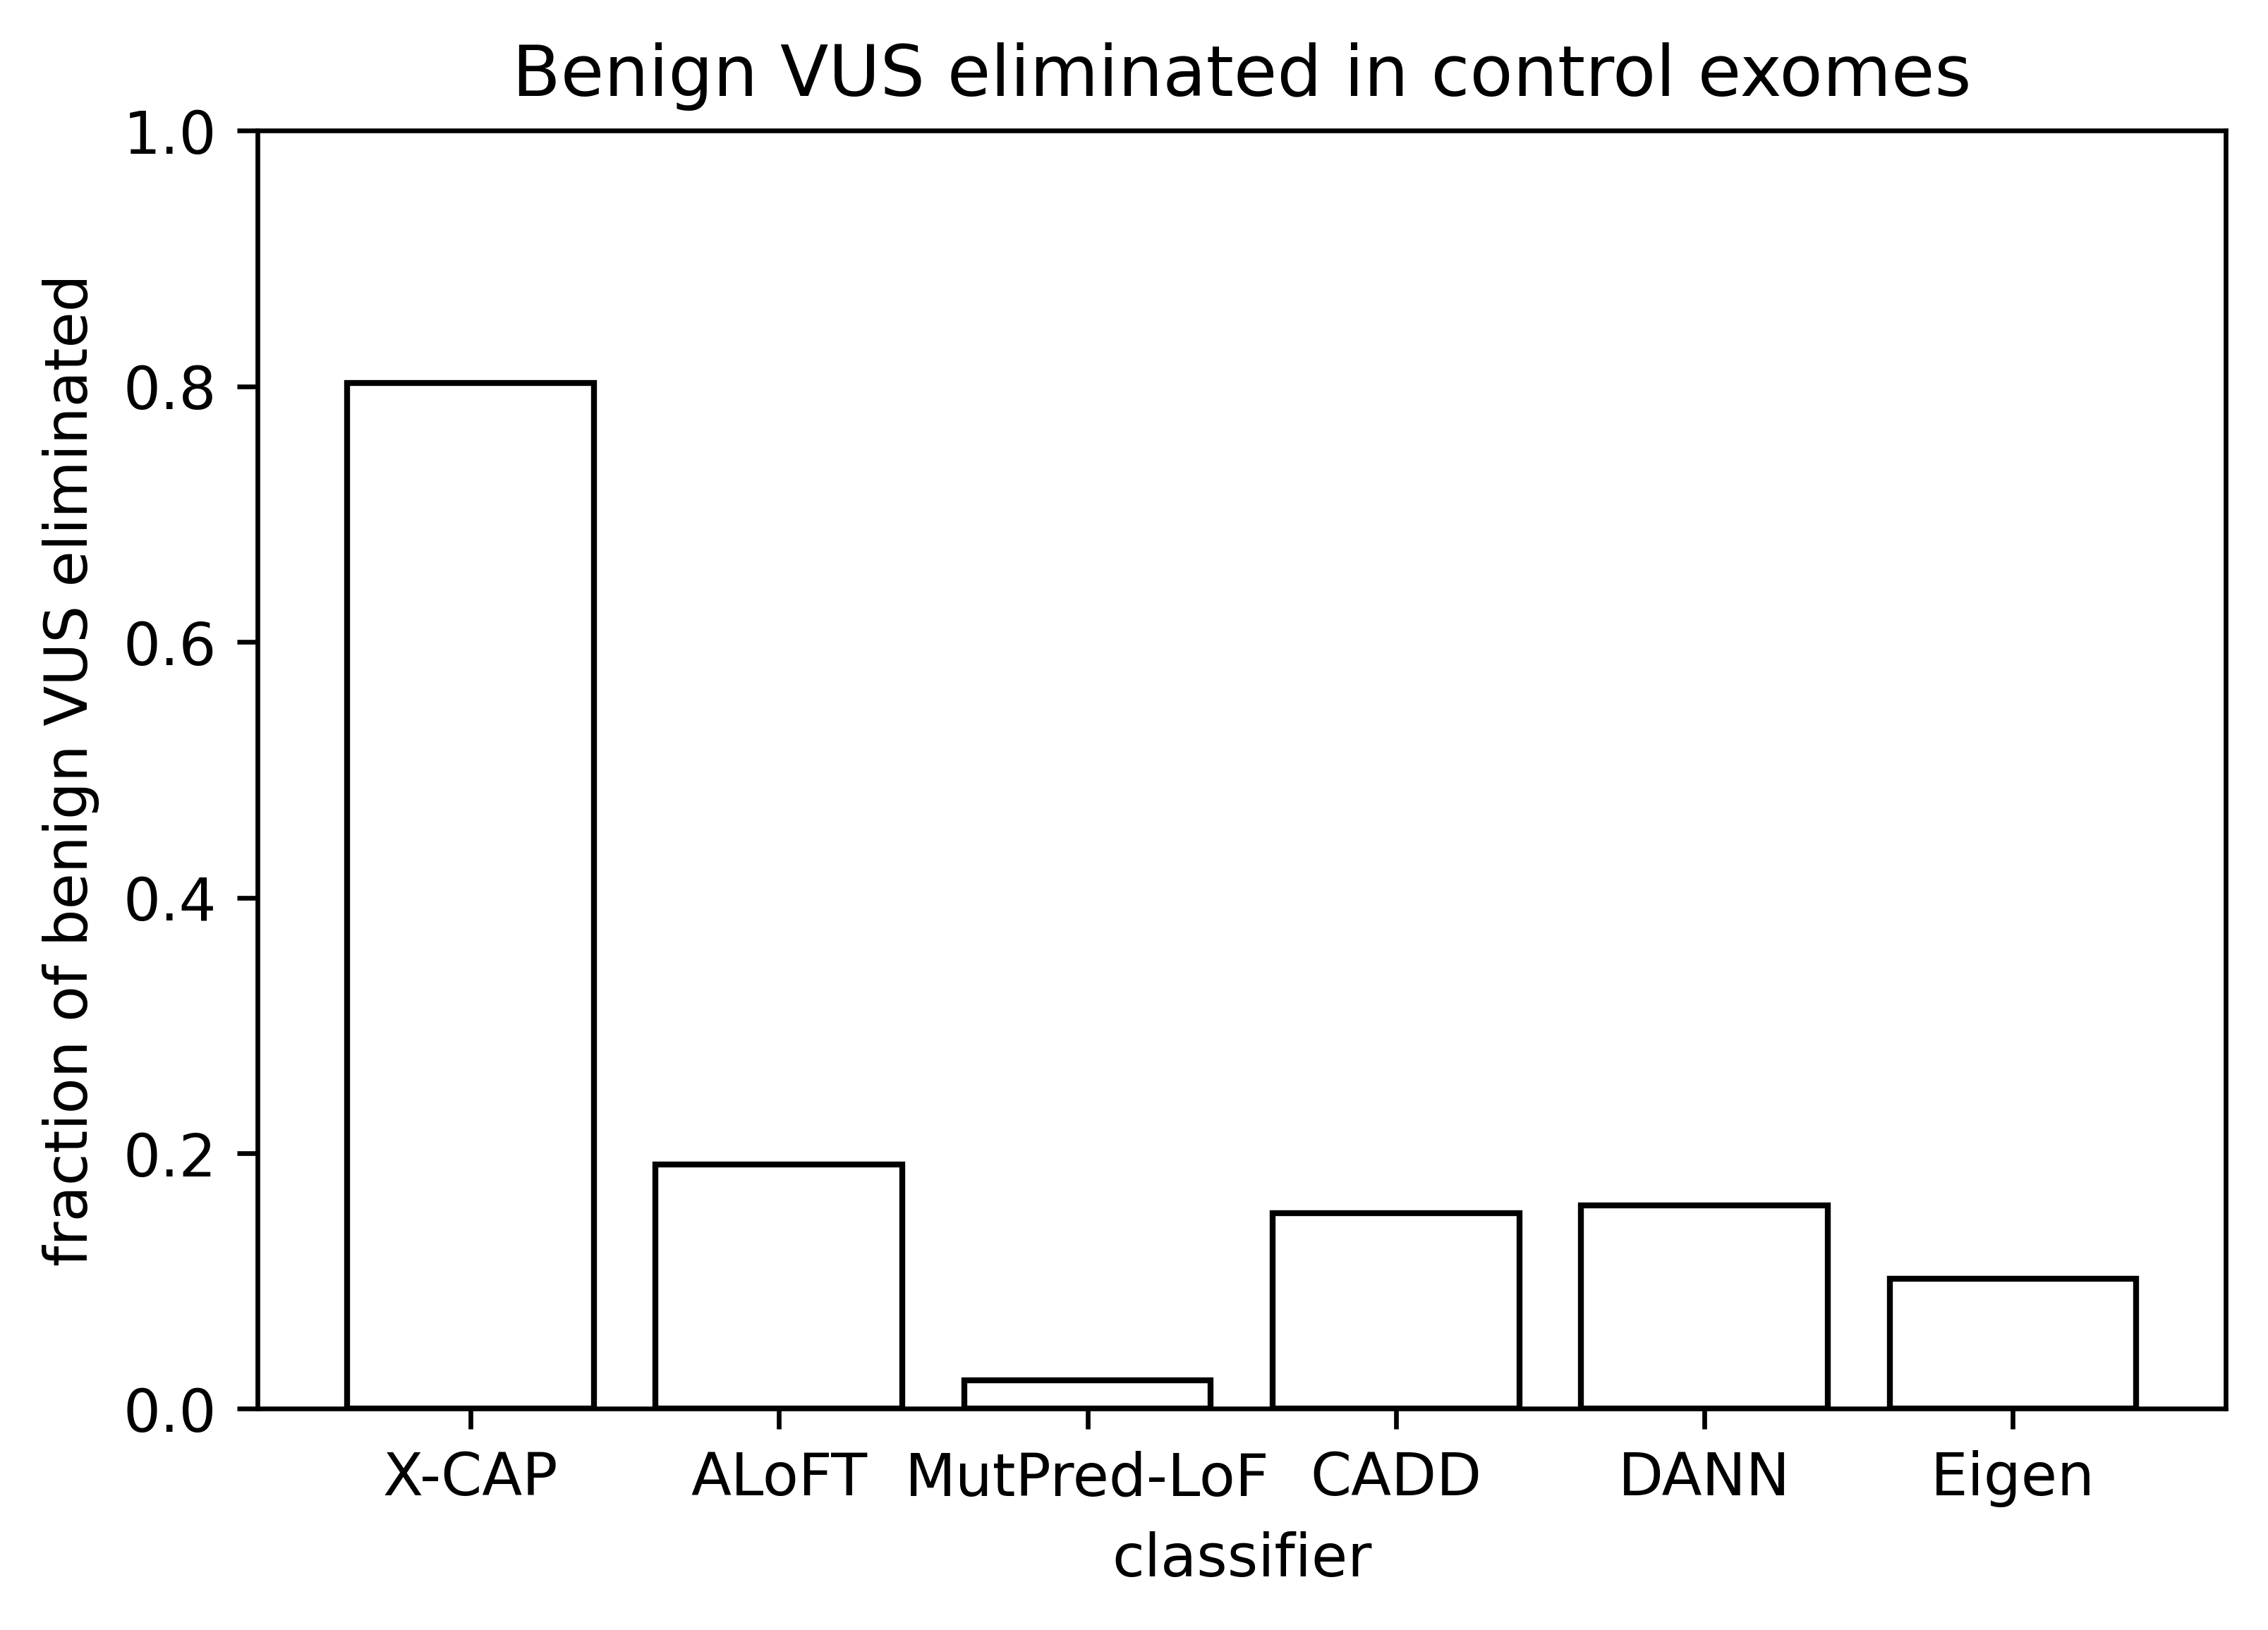

In [29]:
data = [np.asarray(xcap_dbGaP_eliminated), 
        np.asarray(aloft_dbGaP_eliminated), 
        np.asarray(mutpred_dbGaP_eliminated),
        np.asarray(cadd_dbGaP_eliminated),
        np.asarray(dann_dbGaP_eliminated),
        np.asarray(eigen_dbGaP_eliminated)
]
y = [np.mean(arr) for arr in data]

plt.figure(dpi=600)
plt.bar(np.arange(len(y)), y, fill=False)
plt.xticks(np.arange(len(y)), ["X-CAP", "ALoFT", "MutPred-LoF", "CADD", "DANN", "Eigen"])
plt.xlabel("classifier")
plt.ylim([0.0, 1.0])
plt.ylabel("fraction of benign VUS eliminated")
plt.title("Benign VUS eliminated in control exomes")
plt.show()